🔁 Hybrid Model (Log Training → Real Price Evaluation):
Test MSE: 881943552.00
RMSE: 29697.53
Mean Sale Price: 180,007.70
R² Score: 0.8736


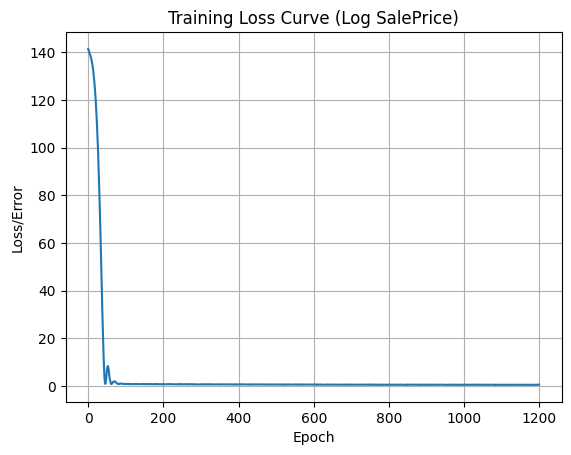

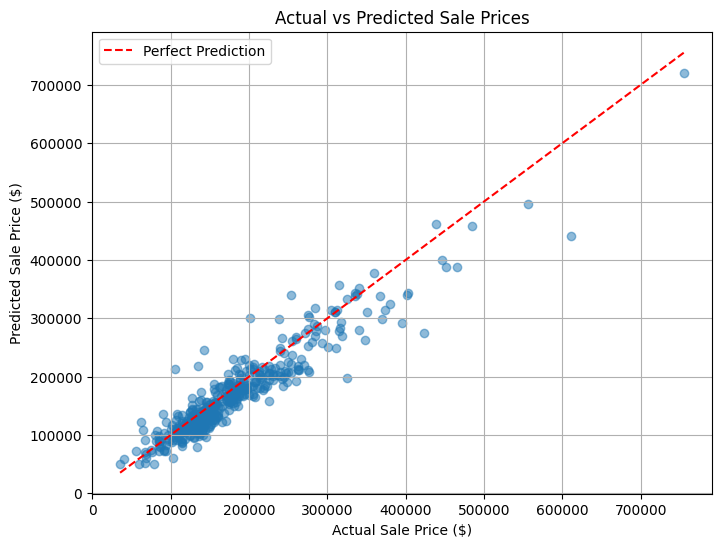

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

#  Define the model class
class ImprovedModel(nn.Module):
    def __init__(self, in_features=80, h1=256, h2=128, h3=64, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        return self.out(x)

#  Load and preprocess the dataset
df = pd.read_csv("train.csv")

# Impute missing values
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
categorical_cols = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope",
                    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
                    "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual",
                    "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir",
                    "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish",
                    "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType",
                    "SaleCondition"]
df[categorical_cols] = df[categorical_cols].fillna("None")

numerical_cols = ["GarageYrBlt", "GarageCars", "GarageArea", "MasVnrArea"]
df[numerical_cols] = df[numerical_cols].fillna(0)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols)

#  Separate features and log-transformed target
y_log = np.log1p(df["SalePrice"].values)
X = df.drop(columns=["SalePrice"])

#  Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "columns_template.pkl")

# 🔹 Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X_scaled, y_log, test_size=0.3, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train_log = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
y_test_log = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

#  Initialize model, loss, optimizer
torch.manual_seed(41)
model = ImprovedModel(in_features=X_train.shape[1], h1=128, h2=64, h3=32, out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)

#  Train the model
epochs = 1200
losses = []

for epoch in range(epochs):
    model.train()
    y_pred_log = model(X_train)
    loss = criterion(y_pred_log, y_train_log)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#  Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions_log = model(X_test).numpy().flatten()
    y_test_log_np = y_test_log.numpy().flatten()

#  Convert log predictions to actual prices
test_predictions = np.expm1(test_predictions_log)
y_test_actual = np.expm1(y_test_log_np)

#  Metrics
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, test_predictions)

print(f"🔁 Hybrid Model (Log Training → Real Price Evaluation):")
print(f"Test MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Mean Sale Price: {y_test_actual.mean():,.2f}")
print(f"R² Score: {r2:.4f}")

#  Plot loss curve
plt.plot(range(epochs), losses)
plt.ylabel("Loss/Error")
plt.xlabel("Epoch")
plt.title("Training Loss Curve (Log SalePrice)")
plt.grid(True)
plt.show()

#  Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, test_predictions, alpha=0.5)
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.title("Actual vs Predicted Sale Prices")
plt.plot([min(y_test_actual), max(y_test_actual)],
         [min(y_test_actual), max(y_test_actual)],
         color='red', linestyle='--', label="Perfect Prediction")
plt.legend()
plt.grid(True)
plt.show()

#  Save the model
torch.save(model.state_dict(), "hybrid_log_model.pt")

In [ ]:
# trying prices for same datapoints but using hybrid approach

In [2]:
import torch
import joblib

#  Load the Excel file
df_input = pd.read_excel("Book1.xlsx")  # Replace with your actual file name

#  Separate actual prices if available
actual_prices = df_input["SalePrice"] if "SalePrice" in df_input.columns else None
features_df = df_input.drop(columns=["SalePrice"], errors="ignore")

#  Fill missing values
features_df["LotFrontage"] = features_df["LotFrontage"].fillna(70.0)  # Use training median
for col in features_df.select_dtypes(include='object').columns:
    features_df[col] = features_df[col].fillna("None")
for col in features_df.select_dtypes(include='number').columns:
    features_df[col] = features_df[col].fillna(0)

#  One-hot encode and align with training columns
df_encoded = pd.get_dummies(features_df)

# Load column template and scaler
columns_template = joblib.load("columns_template.pkl")
scaler = joblib.load("scaler.pkl")

# Reindex to match training columns
df_encoded = df_encoded.reindex(columns=columns_template, fill_value=0)

#  Scale the input
scaled_array = scaler.transform(df_encoded)
input_tensor = torch.tensor(scaled_array, dtype=torch.float32)

#  Define the model architecture
class ImprovedModel(torch.nn.Module):
    def __init__(self, in_features, h1, h2, h3, out_features):
        super(ImprovedModel, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, h1)
        self.fc2 = torch.nn.Linear(h1, h2)
        self.fc3 = torch.nn.Linear(h2, h3)
        self.out = torch.nn.Linear(h3, out_features)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc3(x), negative_slope=0.01)
        return self.out(x)

#  Load the trained hybrid model
model = ImprovedModel(in_features=304, h1=128, h2=64, h3=32, out_features=1)
model.load_state_dict(torch.load("hybrid_log_model.pt"))
model.eval()

#  Make predictions
with torch.no_grad():
    log_preds = model(input_tensor).squeeze().numpy()
    predicted_prices = np.expm1(log_preds)

#  Create a results DataFrame
results_df = pd.DataFrame({
    "PredictedPrice": predicted_prices
})

if actual_prices is not None:
    results_df["ActualPrice"] = actual_prices.values
    results_df["Error"] = results_df["PredictedPrice"] - results_df["ActualPrice"]
    results_df["ErrorPercent"] = 100 * results_df["Error"] / results_df["ActualPrice"]

#  Display results
print(results_df.round(2))

    PredictedPrice  ActualPrice      Error  ErrorPercent
0     94119.617188       129500  -35380.38        -27.32
1    302323.718750       345000  -42676.28        -12.37
2     95502.023438       144000  -48497.98        -33.68
3    175357.343750       279500 -104142.66        -37.26
4    116675.226562       157000  -40324.77        -25.68
5    121132.898438       132000  -10867.10         -8.23
6    119425.609375       149000  -29574.39        -19.85
7     83189.937500        90000   -6810.06         -7.57
8    124909.953125       159000  -34090.05        -21.44
9     95459.773438       139000  -43540.23        -31.32
10   286848.875000       325300  -38451.12        -11.82
11    93813.953125       139400  -45586.05        -32.70
12   169537.046875       230000  -60462.97        -26.29
13    96477.507812       129900  -33422.49        -25.73
14   122244.906250       154000  -31755.09        -20.62
15   207382.656250       256300  -48917.34        -19.09
16   110094.578125       134800

In [3]:
#applying post prediction corrector

#  Apply 7% upward correction
results_df["AdjustedPrice"] = results_df["PredictedPrice"] * 1.07

#  Recalculate error metrics
results_df["AdjustedError"] = results_df["AdjustedPrice"] - results_df["ActualPrice"]
results_df["AdjustedErrorPercent"] = 100 * results_df["AdjustedError"] / results_df["ActualPrice"]

#  Display updated results
print(results_df[["PredictedPrice", "AdjustedPrice", "ActualPrice", "AdjustedError", "AdjustedErrorPercent"]].round(2))

    PredictedPrice  AdjustedPrice  ActualPrice  AdjustedError  \
0     94119.617188  100708.000000       129500      -28792.00   
1    302323.718750  323486.406250       345000      -21513.59   
2     95502.023438  102187.171875       144000      -41812.83   
3    175357.343750  187632.359375       279500      -91867.64   
4    116675.226562  124842.507812       157000      -32157.49   
5    121132.898438  129612.210938       132000       -2387.79   
6    119425.609375  127785.406250       149000      -21214.59   
7     83189.937500   89013.226562        90000        -986.77   
8    124909.953125  133653.640625       159000      -25346.36   
9     95459.773438  102141.960938       139000      -36858.04   
10   286848.875000  306928.312500       325300      -18371.69   
11    93813.953125  100380.937500       139400      -39019.06   
12   169537.046875  181404.625000       230000      -48595.38   
13    96477.507812  103230.937500       129900      -26669.06   
14   122244.906250  13080

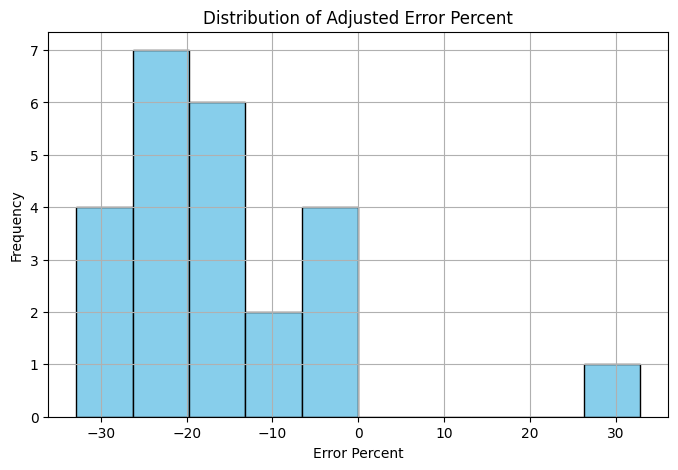

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(results_df["AdjustedErrorPercent"], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Adjusted Error Percent")
plt.xlabel("Error Percent")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()